In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!pip install transformers sentencepiece
!pip install pymorphy2

     |████████████████████████████████| 4.0 MB 4.4 MB/s 
     |████████████████████████████████| 1.2 MB 39.2 MB/s 
     |████████████████████████████████| 6.6 MB 38.8 MB/s 
     |████████████████████████████████| 895 kB 22.9 MB/s 
     |████████████████████████████████| 596 kB 18.5 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 55 kB 1.6 MB/s 
     |████████████████████████████████| 8.2 MB 7.2 MB/s 


In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB

### Загрузка и предобработка данных

In [3]:
# path_train = 'gdrive/MyDrive/СОБЕСЕДОВАНИЯ/kontur/dataset/train.tsv'
# path_test = 'gdrive/MyDrive/СОБЕСЕДОВАНИЯ/kontur/dataset/test.tsv'

!wget https://raw.githubusercontent.com/igorobed/for_test_task/main/test.tsv
!wget https://raw.githubusercontent.com/igorobed/for_test_task/main/train.tsv

path_train = 'train.tsv'
path_test = 'test.tsv'

--2022-04-24 22:38:06--  https://raw.githubusercontent.com/igorobed/for_test_task/main/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120707 (118K) [text/plain]
Saving to: ‘test.tsv’

test.tsv            100%[===================>] 117.88K  --.-KB/s    in 0.02s   

2022-04-24 22:38:06 (4.75 MB/s) - ‘test.tsv’ saved [120707/120707]

--2022-04-24 22:38:06--  https://raw.githubusercontent.com/igorobed/for_test_task/main/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 711584 (695K) [text/plain]
Saving to: ‘train.tsv

In [4]:
df_train = pd.read_csv(path_train, sep='\t')
df_test = pd.read_csv(path_test, sep='\t')

In [ ]:
# Проверим данные на наличие пропусков

print('train')
print(df_train.isnull().sum())
print()
print('test')
print(df_test.isnull().sum())

train
title      0
is_fake    0
dtype: int64

test
title      0
is_fake    0
dtype: int64


In [ ]:
# Проверим данные на наличие дубликатов

print(f'Train number of duplicates - {df_train.duplicated().sum()}')
print(f'Test number of duplicates - {df_test.duplicated().sum()}')

Train number of duplicates - 1
Test number of duplicates - 0


Удалим из обучающих данных дубликат, чтобы не портить качество модели

In [ ]:
# посмотрим на дубликат

df_train.loc[df_train.duplicated(keep=False)]

,title,is_fake
402,В США зафиксировано рекордное количество банкр...,0
624,В США зафиксировано рекордное количество банкр...,0


In [ ]:
# удаление дубликата

origin_train_len = len(df_train)
df_train = df_train.drop(df_train.loc[df_train.duplicated()].index)
df_train.index = range(len(df_train))
assert len(df_train) == (origin_train_len - 1), 'Error while deleting'

Посмотрим на наши данные

In [ ]:
df_train.sample(3)

,title,is_fake
839,"Россия отдаст Беларуси деньги, полученные от п...",1
5019,«Мы готовим перезапуск телепередачи «Форт Бояр...,1
5006,Дети чиновников получат право на бесплатное об...,1


In [ ]:
df_train.sample(3).title.values

array(['Шарапова выложила в соцсеть фотографию с детской коляской',
       '17-летний регбист из Новой Зеландии умер из-за травмы головы',
       'Непонятно, на что намёк: Дмитрий Медведев призвал проверить группу Король и Шут на экстремизм'],
      dtype=object)

In [ ]:
df_test.sample(3)

,title,is_fake
834,Германия вышлет 76 российских дипломатов из-за...,0
606,Гнилостные грибы помогут улучшить звучание скр...,0
313,Эминема пригласили на церемонию введения в Зал...,0


Посмотрим на количество имеющихся у нас данных и сбалансированность классов в датасете для обучения

In [ ]:
print(f'Train - {len(df_train)}')
print(f'Test - {len(df_test)}')

Train - 5757
Test - 1000


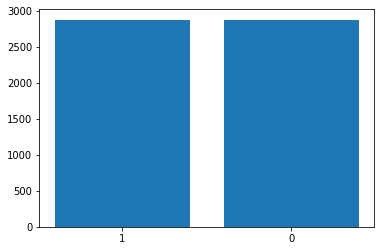

In [ ]:
plt.bar(list(map(str, list(Counter(df_train.is_fake).keys()))), Counter(df_train.is_fake).values());

In [ ]:
df_train.is_fake.value_counts()

1    2879
0    2878
Name: is_fake, dtype: int64

Целевое значение сбалансированно, однако данных довольно мало. Большие и мощные нейронные сети(тот же Bert или многослойный двунаправленный lstm/gru) использовать здесь далеко не тривиальная задача, так как они будут очень легко переобучаться, поэтому из-за ограниченности времени и ресурсов наверное стоит остановиться на классических подходах

Посмотрим на расспределение длин заголовков и количество уникальных слов

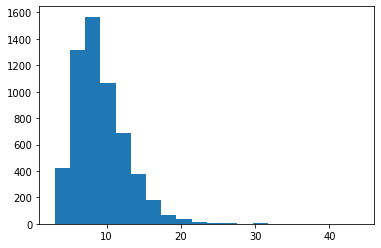

In [ ]:
tk = nltk.WordPunctTokenizer()
title_lens = list(map(lambda x: len(tk.tokenize(x)), df_train.title.values))
plt.hist(title_lens, bins=20);

In [ ]:
print(f'Mean - {np.mean(title_lens)}')
print(f'Median - {np.median(title_lens)}')
print(f'Min - {np.min(title_lens)}')
print(f'Max - {np.max(title_lens)}')

Mean - 9.548028487059232
Median - 9.0
Min - 3
Max - 44


### Бейзлайн

В качестве бейзлайна используем логистическую регрессию и tfidf на биграммах с предварительной лемматизацией предложений с использованием морфологического анализатора pymorphy2

In [9]:
morph = MorphAnalyzer()
tk = nltk.WordPunctTokenizer()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from pandas.core.common import random_state
# в данном случае не надо избавляться от стоп слов и служебных символов, так как таким образом мы може потерять часть информации
def tokenizer_simple(sentence):
  '''
  Простая токенизация предложений на слова и служебные символы
  '''
  return [token.lower() for token in tk.tokenize(sentence)]


def lemmatize_pymorfy(tokens_list):
  '''
  Лемматизация токенов
  '''
  return [morph.normal_forms(token.lower().strip())[0] for token in tokens_list]


def my_tokenizer(sentence):
  '''
  токенизатор для бейзлайна
  '''
  tokens = tokenizer_simple(sentence)
  tokens = lemmatize_pymorfy(tokens)
  return tokens


X = df_train.title.values
y = df_train.is_fake.values
tfidf = TfidfVectorizer(tokenizer=my_tokenizer, ngram_range=(1, 2))
X_feats = tfidf.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_feats, y, shuffle=True, random_state=42)
clf_base = LogisticRegression(random_state=42)
clf_base.fit(X_train, y_train)
preds = clf_base.predict(X_val)
print('Оценка на тесте:')
print(classification_report(y_val, preds))

print('Оценка на кросс-валидации:')
results = cross_val_score(clf_base, X_feats, y, scoring='f1', cv=kfold)
print(results)
print(np.mean(results))

Оценка на тесте:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       721
           1       0.87      0.78      0.82       719

    accuracy                           0.83      1440
   macro avg       0.84      0.83      0.83      1440
weighted avg       0.84      0.83      0.83      1440

Оценка на кросс-валидации:
[0.84412033 0.83467382 0.82949309 0.82624113 0.83695652]
0.8342969776246594


Однако эксперименты показали, что в качестве эмбеддинга предложения лучше использовать дистиллированный русский берт(https://habr.com/ru/post/562064/?)

Загрузим соответствующую модель и веса к ней

In [5]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
# model.cuda()

def embed_bert_cls(text, model, tokenizer):
    '''
    Получить вектор, соответствующий токену, заключающему в себе обобщение(?) обработанного предложения
    '''
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Downloading:   0%|          | 0.00/401 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# получим эмбеддинг каждого заголовка в тренировочном датасете

X = []
for text in df_train.title.values:
  X.append(embed_bert_cls(text, model, tokenizer))

X = np.array(X)
y = df_train.is_fake.values

Посмотрим на новый бейзлайн уже с новыми признаками

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf_base = LogisticRegression(random_state=42)
clf_base.fit(X_train, y_train)
preds = clf_base.predict(X_val)
print('Оценка на тесте:')
print(classification_report(y_val, preds))

print('Оценка на кросс-валидации:')
results = cross_val_score(clf_base, X, y, scoring='f1', cv=kfold)
print(results)
print(np.mean(results))

Оценка на тесте:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       582
           1       0.87      0.86      0.87       570

    accuracy                           0.87      1152
   macro avg       0.87      0.87      0.87      1152
weighted avg       0.87      0.87      0.87      1152

Оценка на кросс-валидации:
[0.87971905 0.85294118 0.86949006 0.87219344 0.87971905]
0.870812555506362


Видим значительный прирост в качестве, а значит в дальнейшем имеет смысл использовать эмбеддинги, получаемы с помощью берта

### Обучение модели и оценка ее работы

In [ ]:
# запилить уже имеющуюся, попробовать настроить байес и соседей и посмотреть на результаты

После того как были проведены эксперименты с разными моделями классификации из библиотеки scikit-learn, лучшие результаты были получены на NuSVC. В итоге был сделан ансамбль моделей, на котором качество классификации немного превосходит качество на отдельно модели NuSVC

In [11]:
estimators = [
              ('rc', RidgeClassifier(alpha=0.1, solver='sag', tol=0.001, random_state=42)),
              ('nsvc', NuSVC(nu=0.2, kernel='poly', degree=5, decision_function_shape='ovo', random_state=42)),
              ('kn', KNeighborsClassifier()),
              ('rf', RandomForestClassifier(n_estimators=200, criterion='gini', random_state=42)),
              ('nb', GaussianNB())
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42), cv=kfold)
clf.fit(X_train, y_train)
preds = clf.predict(X_val)
print('Оценка на тесте:')
print(classification_report(y_val, preds))

print('Оценка на кросс-валидации:')
results = cross_val_score(clf, X, y, scoring='f1', cv=kfold)
print(results)
print(np.mean(results))

Оценка на тесте:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       562
           1       0.92      0.89      0.91       590

    accuracy                           0.90      1152
   macro avg       0.90      0.90      0.90      1152
weighted avg       0.90      0.90      0.90      1152

Оценка на кросс-валидации:
[0.90877498 0.89913043 0.89428076 0.89625109 0.91443388]
0.9025742292305698


In [ ]:
clf.score(X_val, y_val)

0.9019097222222222

Гиперпараметры для RidgeClassifier, NuSVC и RandomForestClassifier были получены мной ранее с помощью поиска по сетке. Теперь таким же образом попробуем подобрать оптимальные параметры для KNeighborsClassifier и посмотрим, не получится ли улучшить качество

In [ ]:
def get_scores(clf, X, y, X_val, y_val, cv=5):
  '''
  Печать результатов модели на тесте и кросс-валидации
  '''
  preds = clf.predict(X_val)
  print('Оценка на тесте:')
  print(classification_report(y_val, preds))

  print('Оценка на кросс-валидации:')
  results = cross_val_score(clf, X, y, scoring='f1', cv=cv)
  print(results)
  print(np.mean(results))

**KNeighbours**

In [ ]:
# сначала посмотрим на качество работы с дефолтными параметрами

kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)
get_scores(kn_clf, X, y, X_val, y_val, cv=kfold)

Оценка на тесте:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       582
           1       0.87      0.84      0.86       570

    accuracy                           0.86      1152
   macro avg       0.86      0.86      0.86      1152
weighted avg       0.86      0.86      0.86      1152

Оценка на кросс-валидации:
[0.85185185 0.86713287 0.84083045 0.84303351 0.84697509]
0.8499647534959711


In [ ]:
# теперь воспользуемся GridSearchCV
'''
kn_configs = {
    'n_neighbors': [3, 5, 7], 
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1, 2]
}
'''

kn_configs = {
    'n_neighbors': [20, 22, 25, 27], 
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto'], 
    'p': [1, 2]
}

kn_clf = KNeighborsClassifier()

clf_cv = GridSearchCV(kn_clf, kn_configs, cv=kfold, scoring='f1', verbose=1)
search = clf_cv.fit(X, y)
print(search.best_params_)
print(search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'algorithm': 'auto', 'n_neighbors': 22, 'p': 1, 'weights': 'distance'}
0.8673343573837103


Соберем финальную модель и посмотрим на ее качество

In [ ]:
estimators = [
              ('rc', RidgeClassifier(alpha=0.1, solver='sag', tol=0.001, random_state=42)),
              ('nsvc', NuSVC(nu=0.2, kernel='poly', degree=5, decision_function_shape='ovo', random_state=42)),
              ('kn', KNeighborsClassifier(algorithm='auto', n_neighbors=22, p=1, weights='distance')),
              ('rf', RandomForestClassifier(n_estimators=200, criterion='gini', random_state=42)),
              ('nb', GaussianNB())
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42), cv=kfold)
clf.fit(X_train, y_train)
preds = clf.predict(X_val)
print('Оценка на тесте:')
print(classification_report(y_val, preds))

Оценка на тесте:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       582
           1       0.90      0.89      0.89       570

    accuracy                           0.89      1152
   macro avg       0.90      0.89      0.89      1152
weighted avg       0.90      0.89      0.89      1152



In [ ]:
print('Оценка на кросс-валидации:')
results = cross_val_score(clf, X, y, scoring='f1', cv=kfold)
print(results)
print(np.mean(results))

Оценка на кросс-валидации:
[0.89913043 0.89817232 0.90328152 0.89387403 0.91695502]
0.9022826650081806


Видим ухудшение результатов, поэтому вернемся к предыдущей модели с дефолтными параметрами KNeighboursClassifier

In [ ]:
estimators = [
              ('rc', RidgeClassifier(alpha=0.1, solver='sag', tol=0.001)),
              ('nsvc', NuSVC(nu=0.2, kernel='poly', degree=5, decision_function_shape='ovo')),
              ('kn', KNeighborsClassifier()),
              ('rf', RandomForestClassifier(n_estimators=200, criterion='gini')),
              ('nb', GaussianNB())
]

final_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=kfold)

# обучение его на всем трэйне
final_clf.fit(X, y)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('rc', RidgeClassifier(alpha=0.1, solver='sag')),
                               ('nsvc',
                                NuSVC(decision_function_shape='ovo', degree=5,
                                      kernel='poly', nu=0.2)),
                               ('kn', KNeighborsClassifier()),
                               ('rf', RandomForestClassifier(n_estimators=200)),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression())

### Предсказания на тесте

In [ ]:
# получим эмбеддинги тестовых заголовков

X_test = []
for text in df_test.title.values:
  X_test.append(embed_bert_cls(text, model, tokenizer))

X_test = np.array(X_test)

In [ ]:
final_preds = final_clf.predict(X_test)

In [ ]:
df_test.is_fake = final_preds

In [ ]:
df_test.sample(5)

,title,is_fake
287,МОК включил в программу зимних Олимпиад четыре...,0
695,РЖД сделает платными туалеты в поездах,1
257,Европа пригрозила Греции экономическими санкциями,0
152,ОАК оставила единственного покупателя без Ту-214,0
225,В связи с беспрецедентными туманами Сергей Лав...,1


In [ ]:
df_test.to_csv('predictions.tsv', sep='\t', index=False)